In [104]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
import tensorflow as tf
from tensorflow import keras

import IPython

!pip install -U keras-tuner
import kerastuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [106]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [107]:
# Importing Training Set
dataset_train = pd.read_csv('/content/gdrive/My Drive/datasets/GOOG.csv')

print(dataset_train.head())

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print(datelist_train)

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

         Date        Open        High  ...       Close   Adj Close   Volume
0  2008-08-22  244.832306  246.515991  ...  244.379013  244.379013  4611500
1  2008-08-25  242.147369  247.572037  ...  240.603165  240.603165  4043600
2  2008-08-26  240.827316  240.827316  ...  236.194687  236.194687  6641100
3  2008-08-27  235.980484  236.528427  ...  233.415100  233.415100  8807000
4  2008-08-28  235.362808  237.335403  ...  236.005386  236.005386  6082000

[5 rows x 7 columns]
[datetime.date(2008, 8, 22), datetime.date(2008, 8, 25), datetime.date(2008, 8, 26), datetime.date(2008, 8, 27), datetime.date(2008, 8, 28), datetime.date(2008, 8, 29), datetime.date(2008, 9, 2), datetime.date(2008, 9, 3), datetime.date(2008, 9, 4), datetime.date(2008, 9, 5), datetime.date(2008, 9, 8), datetime.date(2008, 9, 9), datetime.date(2008, 9, 10), datetime.date(2008, 9, 11), datetime.date(2008, 9, 12), datetime.date(2008, 9, 15), datetime.date(2008, 9, 16), datetime.date(2008, 9, 17), datetime.date(2008, 9, 

In [108]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (2998, 5).


array([[ 244.832306,  246.515991,  243.82608 ,  244.379013,  244.379013],
       [ 242.147369,  247.572037,  239.850983,  240.603165,  240.603165],
       [ 240.827316,  240.827316,  234.416351,  236.194687,  236.194687],
       ...,
       [1521.619995, 1523.439941, 1498.420044, 1515.550049, 1515.550049],
       [1515.26001 , 1570.290039, 1503.599976, 1565.719971, 1565.719971],
       [1586.98999 , 1586.98999 , 1554.280029, 1558.420044, 1558.420044]])

In [109]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

training_set_scaled

array([[-1.03988439, -1.04063569, -1.03585083, -1.04020883, -1.04020883],
       [-1.04718024, -1.03779417, -1.04674835, -1.05045548, -1.05045548],
       [-1.05076726, -1.05594234, -1.06164711, -1.06241891, -1.06241891],
       ...,
       [ 2.42956569,  2.39521192,  2.40355288,  2.40940922,  2.40940922],
       [ 2.41228353,  2.52127252,  2.41775339,  2.54555696,  2.54555696],
       [ 2.60719737,  2.56620745,  2.5566901 ,  2.52574691,  2.52574691]])

In [110]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want to predict into the future (lag size)
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)


print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2849, 90, 4).
y_train shape == (2849, 1).


In [111]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [112]:
def model_builder(hp):
  model = Sequential()
  model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  # Adding 2nd LSTM layer
  model.add(LSTM(units = hp_units, return_sequences=False))
  # Adding Dropout
  model.add(Dropout(hp.Choice('dropout' + str(i), values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
  # model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  # model.add(keras.layers.Dense(10))

  # Output layer
  model.add(Dense(units=1, activation='linear'))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  #hP_opt = hp.Choice('', values = ['adam', '', 1e-4])
  
  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'mean_squared_error')
  
  return model

In [113]:
tuner_randomSearch = kerastuner.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'kerastuner')

INFO:tensorflow:Reloading Oracle from existing project my_dir/kerastuner/oracle.json


INFO:tensorflow:Reloading Oracle from existing project my_dir/kerastuner/oracle.json


INFO:tensorflow:Reloading Tuner from my_dir/kerastuner/tuner0.json


INFO:tensorflow:Reloading Tuner from my_dir/kerastuner/tuner0.json


In [114]:
tuner_baysianSearch = kerastuner.BayesianOptimization(model_builder,
                     objective = 'val_loss',
                     max_trials = 5)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [115]:

#history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)
tuner_randomSearch.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)

# Get the optimal hyperparameters
best_hps_randomSearch = tuner_randomSearch.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_randomSearch.get('units')} and the optimal learning rate for the optimizer
is {best_hps_randomSearch.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64 and the optimal learning rate for the optimizer
is 0.001.



In [116]:

#history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)
tuner_baysianSearch.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)

# Get the optimal hyperparameters
best_hps_baysianSearch = tuner_baysianSearch.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_baysianSearch.get('units')} and the optimal learning rate for the optimizer
is {best_hps_baysianSearch.get('learning_rate')}.
""")

Epoch 1/10
9/9 [==============================] - 5s 548ms/step - loss: 0.5680 - val_loss: 0.1440
Epoch 2/10
9/9 [==============================] - 4s 475ms/step - loss: 0.0501 - val_loss: 0.1818
Epoch 3/10
9/9 [==============================] - 4s 477ms/step - loss: 0.0303 - val_loss: 0.1266
Epoch 4/10
9/9 [==============================] - 4s 475ms/step - loss: 0.0247 - val_loss: 0.1158
Epoch 5/10
9/9 [==============================] - 4s 478ms/step - loss: 0.0227 - val_loss: 0.1270
Epoch 6/10
9/9 [==============================] - 4s 477ms/step - loss: 0.0211 - val_loss: 0.1142
Epoch 7/10
9/9 [==============================] - 4s 477ms/step - loss: 0.0207 - val_loss: 0.1137
Epoch 8/10
9/9 [==============================] - 4s 477ms/step - loss: 0.0204 - val_loss: 0.1409
Epoch 9/10
9/9 [==============================] - 5s 508ms/step - loss: 0.0200 - val_loss: 0.1202
Epoch 10/10
9/9 [==============================] - 4s 471ms/step - loss: 0.0201 - val_loss: 0.1329


Epoch 1/10
9/9 [==============================] - 17s 2s/step - loss: 6.5758 - val_loss: 0.2551
Epoch 2/10
9/9 [==============================] - 16s 2s/step - loss: 0.0702 - val_loss: 1.0522
Epoch 3/10
9/9 [==============================] - 16s 2s/step - loss: 0.5556 - val_loss: 0.4088
Epoch 4/10
9/9 [==============================] - 16s 2s/step - loss: 1.0225 - val_loss: 0.3335
Epoch 5/10
9/9 [==============================] - 16s 2s/step - loss: 1.2895 - val_loss: 4.6362
Epoch 6/10
9/9 [==============================] - 16s 2s/step - loss: 0.7928 - val_loss: 3.1786
Epoch 7/10
9/9 [==============================] - 16s 2s/step - loss: 0.5586 - val_loss: 1.2666
Epoch 8/10
9/9 [==============================] - 16s 2s/step - loss: 0.4429 - val_loss: 2.1536
Epoch 9/10
9/9 [==============================] - 16s 2s/step - loss: 0.3745 - val_loss: 1.1721
Epoch 10/10
9/9 [==============================] - 16s 2s/step - loss: 0.3462 - val_loss: 1.0896


Epoch 1/10
9/9 [==============================] - 27s 3s/step - loss: 11.3431 - val_loss: 2.8153
Epoch 2/10
9/9 [==============================] - 27s 3s/step - loss: 0.6829 - val_loss: 1.1456
Epoch 3/10
9/9 [==============================] - 26s 3s/step - loss: 0.3553 - val_loss: 0.9563
Epoch 4/10
9/9 [==============================] - 27s 3s/step - loss: 0.1755 - val_loss: 0.1276
Epoch 5/10
9/9 [==============================] - 26s 3s/step - loss: 0.0788 - val_loss: 0.3767
Epoch 6/10
9/9 [==============================] - 27s 3s/step - loss: 0.0491 - val_loss: 0.1431
Epoch 7/10
9/9 [==============================] - 27s 3s/step - loss: 0.0443 - val_loss: 0.3429
Epoch 8/10
9/9 [==============================] - 26s 3s/step - loss: 0.0344 - val_loss: 0.4420
Epoch 9/10
9/9 [==============================] - 27s 3s/step - loss: 0.0354 - val_loss: 0.3169
Epoch 10/10
9/9 [==============================] - 27s 3s/step - loss: 0.0350 - val_loss: 0.3224


Epoch 1/10
9/9 [==============================] - 12s 1s/step - loss: 0.1510 - val_loss: 0.1794
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.0365 - val_loss: 0.1819
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.0264 - val_loss: 0.1606
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.0241 - val_loss: 0.1398
Epoch 5/10
9/9 [==============================] - 12s 1s/step - loss: 0.0233 - val_loss: 0.1161
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.0215 - val_loss: 0.1296
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.0214 - val_loss: 0.1292
Epoch 8/10
9/9 [==============================] - 11s 1s/step - loss: 0.0218 - val_loss: 0.1219
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.0216 - val_loss: 0.1303
Epoch 10/10
9/9 [==============================] - 11s 1s/step - loss: 0.0217 - val_loss: 0.1281


Epoch 1/10
9/9 [==============================] - 14s 2s/step - loss: 0.9365 - val_loss: 0.7318
Epoch 2/10
9/9 [==============================] - 13s 1s/step - loss: 0.4175 - val_loss: 0.4474
Epoch 3/10
9/9 [==============================] - 13s 1s/step - loss: 0.3298 - val_loss: 5.3255
Epoch 4/10
9/9 [==============================] - 13s 1s/step - loss: 0.2481 - val_loss: 6.1379
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 0.1670 - val_loss: 4.6405
Epoch 6/10
9/9 [==============================] - 13s 1s/step - loss: 0.1299 - val_loss: 3.7988
Epoch 7/10
9/9 [==============================] - 13s 1s/step - loss: 0.0994 - val_loss: 4.2047
Epoch 8/10
9/9 [==============================] - 13s 1s/step - loss: 0.0955 - val_loss: 0.7067
Epoch 9/10
9/9 [==============================] - 13s 1s/step - loss: 0.0815 - val_loss: 3.3498
Epoch 10/10
9/9 [==============================] - 13s 1s/step - loss: 0.0697 - val_loss: 2.9882


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.01.



In [118]:
hps = []
hps.append(best_hps_randomSearch)
hps.append(best_hps_baysianSearch)
# tun = []
# tun.append(tuner_randomSearch)
# tun.append(tuner_baysianSearch)
models = []


# Build the model with the optimal hyperparameters and train it on the data
model = tuner_randomSearch.hypermodel.build(hps[0])
#tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)
model.fit(X_train, y_train, epochs = 10, validation_split=0.2)

models.append(model)

model = tuner_baysianSearch.hypermodel.build(hps[1])
#tuner.search(X_train, y_train, epochs = 10, validation_split=0.2, batch_size=256)
model.fit(X_train, y_train, epochs = 10, validation_split=0.2)

models.append(model)

Epoch 1/10
72/72 [==============================] - 8s 105ms/step - loss: 0.0615 - val_loss: 0.1222
Epoch 2/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0425 - val_loss: 0.1158
Epoch 3/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0421 - val_loss: 0.1858
Epoch 4/10
72/72 [==============================] - 7s 102ms/step - loss: 0.0403 - val_loss: 0.1240
Epoch 5/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0389 - val_loss: 0.1474
Epoch 6/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0364 - val_loss: 0.1385
Epoch 7/10
72/72 [==============================] - 7s 102ms/step - loss: 0.0367 - val_loss: 0.1719
Epoch 8/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0387 - val_loss: 0.2239
Epoch 9/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0387 - val_loss: 0.1382
Epoch 10/10
72/72 [==============================] - 7s 101ms/step - loss: 0.0363 - val_loss: 0.1243

In [119]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
print(datelist_future)
'''
Remeber, we have datelist_train from begining.
'''
print("___________________________________________________________________________________________")
# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

[Timestamp('2020-07-21 00:00:00', freq='D'), Timestamp('2020-07-22 00:00:00', freq='D'), Timestamp('2020-07-23 00:00:00', freq='D'), Timestamp('2020-07-24 00:00:00', freq='D'), Timestamp('2020-07-25 00:00:00', freq='D'), Timestamp('2020-07-26 00:00:00', freq='D'), Timestamp('2020-07-27 00:00:00', freq='D'), Timestamp('2020-07-28 00:00:00', freq='D'), Timestamp('2020-07-29 00:00:00', freq='D'), Timestamp('2020-07-30 00:00:00', freq='D'), Timestamp('2020-07-31 00:00:00', freq='D'), Timestamp('2020-08-01 00:00:00', freq='D'), Timestamp('2020-08-02 00:00:00', freq='D'), Timestamp('2020-08-03 00:00:00', freq='D'), Timestamp('2020-08-04 00:00:00', freq='D'), Timestamp('2020-08-05 00:00:00', freq='D'), Timestamp('2020-08-06 00:00:00', freq='D'), Timestamp('2020-08-07 00:00:00', freq='D'), Timestamp('2020-08-08 00:00:00', freq='D'), Timestamp('2020-08-09 00:00:00', freq='D'), Timestamp('2020-08-10 00:00:00', freq='D'), Timestamp('2020-08-11 00:00:00', freq='D'), Timestamp('2020-08-12 00:00:00'

In [120]:
# Perform predictions Random Search
predictions_future_randomSearch = models[0].predict(X_train[-n_future:])

predictions_train_randomSearch = models[0].predict(X_train[n_past:])

sc_predict_randomSearch = StandardScaler()
sc_predict_randomSearch.fit_transform(training_set[:, 0:1])



# Perform predictions Bausian Search
predictions_future_BaysianSearch = models[1].predict(X_train[-n_future:])

predictions_train_BaysianSearch = models[1].predict(X_train[n_past:])

sc_predict_BaysianSearch = StandardScaler()
sc_predict_BaysianSearch.fit_transform(training_set[:, 0:1])

array([[-1.03988439],
       [-1.04718024],
       [-1.05076726],
       ...,
       [ 2.42956569],
       [ 2.41228353],
       [ 2.60719737]])

In [121]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future_random = sc_predict_randomSearch.inverse_transform(predictions_future_randomSearch)
y_pred_train_random = sc_predict_randomSearch.inverse_transform(predictions_train_randomSearch)


y_pred_future_baysian = sc_predict_BaysianSearch.inverse_transform(predictions_future_BaysianSearch)
y_pred_train_baysian = sc_predict_BaysianSearch.inverse_transform(predictions_train_BaysianSearch)

PREDICTIONS_FUTURE_RANDOM = pd.DataFrame(y_pred_future_random, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_RANDOM = pd.DataFrame(y_pred_train_random, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))



PREDICTIONS_FUTURE_BAYSIAN = pd.DataFrame(y_pred_future_baysian, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN_BAYSIAN = pd.DataFrame(y_pred_train_baysian, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))


# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_RANDOM.index = PREDICTION_TRAIN_RANDOM.index.to_series().apply(datetime_to_timestamp)

print(PREDICTION_TRAIN_BAYSIAN.head(3))


# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN_BAYSIAN.index = PREDICTION_TRAIN_BAYSIAN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN_BAYSIAN.head(3)

                  Open
2009-08-05  257.609344
2009-08-06  257.748779
2009-08-07  256.869385


,Open
2009-08-05,257.609344
2009-08-06,257.748779
2009-08-07,256.869385


In [122]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)

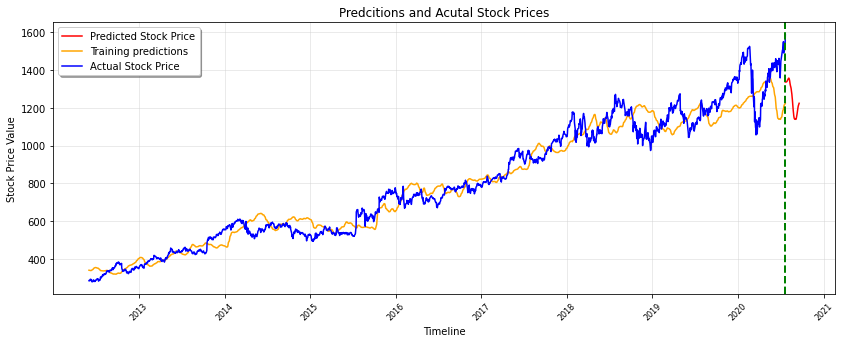

In [123]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE_RANDOM.index, PREDICTIONS_FUTURE_RANDOM['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN_RANDOM.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_RANDOM.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE_RANDOM.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

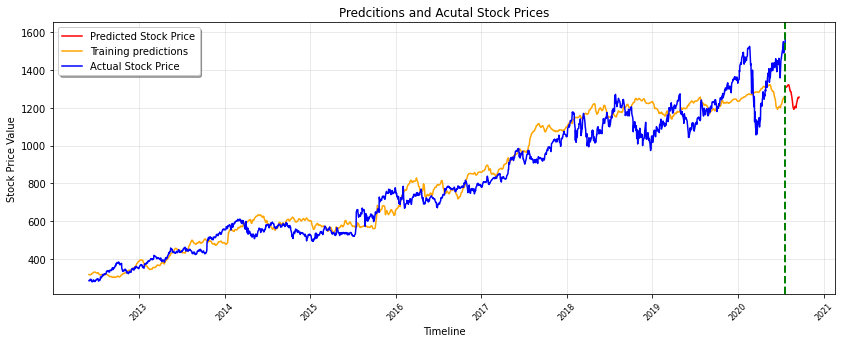

In [124]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE_BAYSIAN.index, PREDICTIONS_FUTURE_BAYSIAN['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN_BAYSIAN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_BAYSIAN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE_BAYSIAN.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()